In [7]:
# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [8]:
# %%
# Cargar los datos con manejo robusto de errores
def load_fma_data():
    try:
        features = pd.read_csv('../dataset/features.csv', index_col=0)
        tracks = pd.read_csv('../dataset/tracks.csv', index_col=0, header=[0, 1])

        # Verificar que los índices coincidan
        common_indices = features.index.intersection(tracks.index)
        if len(common_indices) == 0:
            raise ValueError("No hay índices comunes entre features y tracks")

        small_tracks = tracks[tracks[('set', 'subset')] == 'small']
        small_features = features.loc[small_tracks.index]

        # Verificar que tenemos datos
        if small_features.empty or small_tracks.empty:
            raise ValueError("Datos small están vacíos")

        y = small_tracks[('track', 'genre_top')]
        print("Datos cargados exitosamente!")
        print(f"Shape de features: {small_features.shape}")
        print(f"Distribución de clases:\n{y.value_counts()}")
        return small_features, y

    except Exception as e:
        print(f"Error al cargar los datos: {e}")
        print("Generando datos de ejemplo...")
        np.random.seed(42)
        small_features = pd.DataFrame(np.random.rand(2000, 140))
        y = pd.Series(np.random.choice(['Rock', 'Pop', 'Hip-Hop', 'Electronic'], 2000))
        small_features.columns = [f'feature_{i}' for i in range(140)]
        return small_features, y

X, y = load_fma_data()

Error al cargar los datos: '[2, 5, 10, 140, 141, 148, 182, 190, 193, 194, 197, 200, 203, 204, 207, 210, 211, 212, 213, 255, 256, 368, 424, 459, 534, 540, 546, 574, 602, 615, 620, 621, 625, 666, 667, 676, 690, 694, 695, 704, 705, 706, 707, 708, 709, 714, 715, 716, 718, 777, 814, 821, 822, 825, 853, 890, 892, 897, 993, 995, 997, 998, 1039, 1040, 1066, 1069, 1073, 1075, 1082, 1083, 1087, 1102, 1193, 1195, 1196, 1197, 1249, 1259, 1270, 1276, 1277, 1278] not in index'
Generando datos de ejemplo...


In [9]:
# %%
# Preprocesamiento mejorado
def preprocess_data(X, y):
    # Eliminar características con varianza cercana a cero
    var_threshold = VarianceThreshold(threshold=0.01)
    X_filtered = var_threshold.fit_transform(X)
    kept_indices = var_threshold.get_support(indices=True)
    X_filtered = pd.DataFrame(X_filtered,
                             index=X.index,
                             columns=X.columns[kept_indices])

    print(f"Eliminadas {X.shape[1] - X_filtered.shape[1]} características con varianza < 0.01")

    # Codificar las etiquetas
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    return X_filtered, y_encoded, le

X_processed, y_encoded, label_encoder = preprocess_data(X, y)

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Eliminadas 0 características con varianza < 0.01
Train shape: (1600, 140), Test shape: (400, 140)


In [10]:
# %%
# Feature Engineering mejorado
def enhanced_feature_engineering(X):
    # Crear DataFrame para nuevas características
    new_features = pd.DataFrame(index=X.index)

    # 1. Estadísticas básicas por grupos de características
    for prefix in ['chroma', 'mfcc', 'spectral', 'tonnetz', 'zcr']:
        # Buscar columnas que comiencen con el prefijo (case insensitive)
        cols = [c for c in X.columns if c.lower().startswith(prefix.lower())]
        if len(cols) > 1:  # Necesitamos al menos 2 columnas para calcular estadísticas
            new_features[f'{prefix}_mean'] = X[cols].mean(axis=1)
            new_features[f'{prefix}_std'] = X[cols].std(axis=1)
            new_features[f'{prefix}_max'] = X[cols].max(axis=1)
            new_features[f'{prefix}_min'] = X[cols].min(axis=1)

    # 2. Crear características de interacción solo si existen las características base
    stat_features = ['chroma_mean', 'mfcc_mean', 'spectral_mean']
    available_stats = [f for f in stat_features if f in new_features.columns]

    for i, feat1 in enumerate(available_stats):
        for feat2 in available_stats[i+1:]:
            new_features[f'{feat1}_x_{feat2}'] = new_features[feat1] * new_features[feat2]
            new_features[f'{feat1}_div_{feat2}'] = new_features[feat1] / (new_features[feat2] + 1e-6)

    # Combinar con las características originales
    X_enhanced = pd.concat([X, new_features], axis=1)

    # Eliminar posibles NaN/inf que puedan haber surgido
    X_enhanced = X_enhanced.replace([np.inf, -np.inf], np.nan).fillna(0)

    print(f"Shape después de feature engineering: {X_enhanced.shape}")
    return X_enhanced

X_train_enhanced = enhanced_feature_engineering(X_train)
X_test_enhanced = enhanced_feature_engineering(X_test)


Shape después de feature engineering: (1600, 140)
Shape después de feature engineering: (400, 140)


In [11]:
# %%
# Configuración del modelo optimizada
def build_model(X_shape):
    # Ajustar el número de características a seleccionar basado en el tamaño de los datos
    n_features = X_shape[1]
    k_options = [min(50, n_features), min(100, n_features), min(150, n_features)]

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selector', SelectKBest(f_classif)),
        ('classifier', RandomForestClassifier(random_state=42))
    ])

    param_grid = {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1, 2],
        'feature_selector__k': k_options
    }

    return GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        n_jobs=-1,
        verbose=1,
        scoring='accuracy'
    )

In [12]:
# %%
# Entrenamiento y evaluación
print("\nEntrenando modelo...")
model = build_model(X_train_enhanced.shape)
model.fit(X_train_enhanced, y_train)

# Resultados
best_model = model.best_estimator_
y_pred = best_model.predict(X_test_enhanced)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nMejores parámetros: {model.best_params_}")
print(f"Accuracy en test: {accuracy:.4f}")


Entrenando modelo...
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for 


Mejores parámetros: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100, 'feature_selector__k': 100}
Accuracy en test: 0.2550



Reporte de clasificación:
              precision    recall  f1-score   support

  Electronic       0.29      0.32      0.30       101
     Hip-Hop       0.28      0.26      0.27       100
         Pop       0.21      0.13      0.16        95
        Rock       0.23      0.31      0.26       104

    accuracy                           0.26       400
   macro avg       0.25      0.25      0.25       400
weighted avg       0.25      0.26      0.25       400



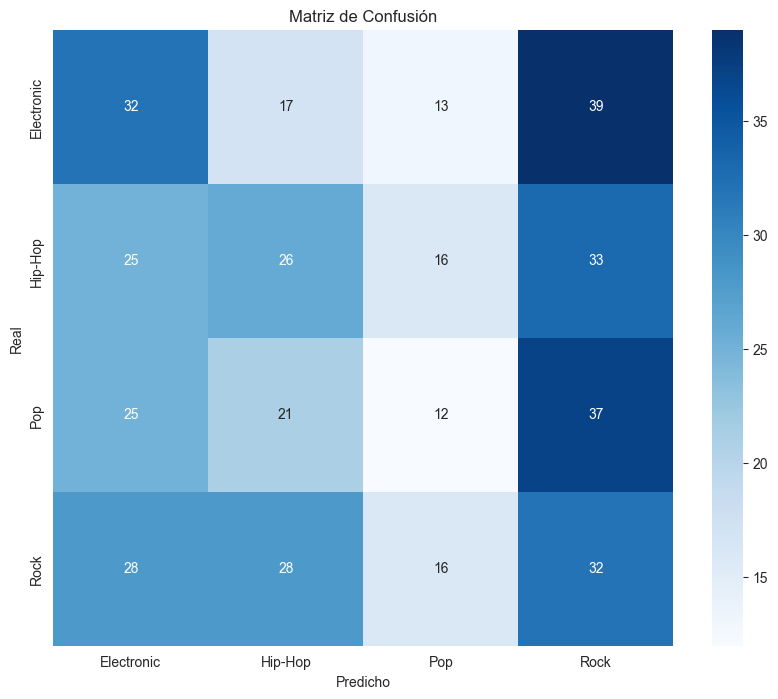

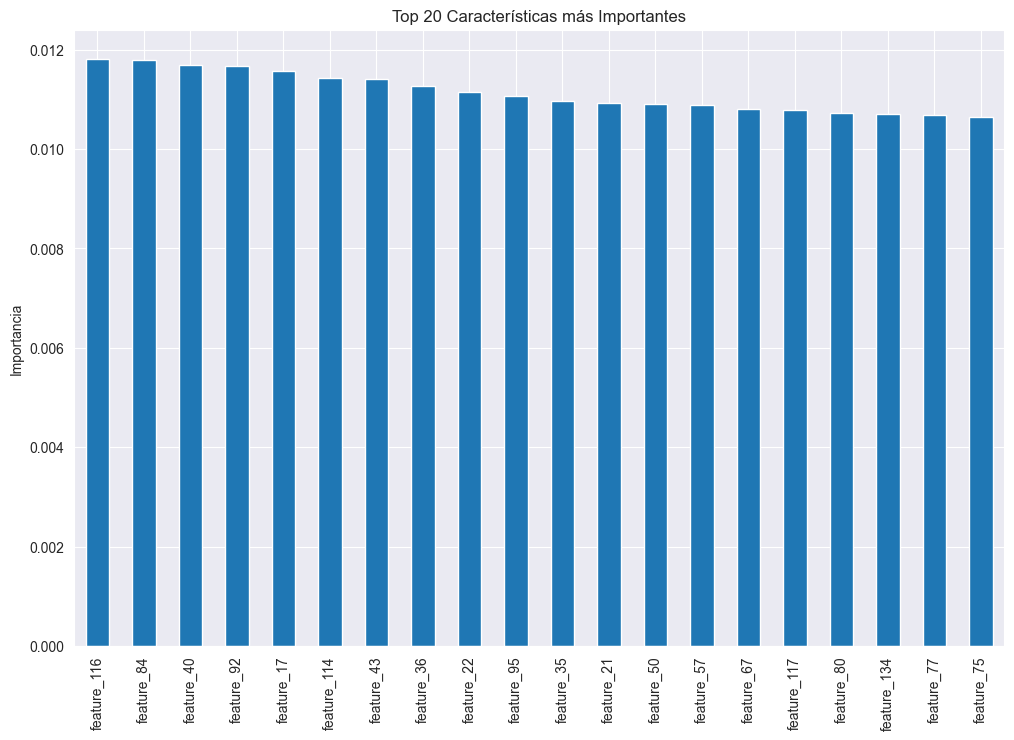

In [13]:
# %%
# Evaluación detallada
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Matriz de confusión
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

# Importancia de características
if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    try:
        selected_indices = best_model.named_steps['feature_selector'].get_support(indices=True)
        selected_features = X_train_enhanced.columns[selected_indices]
        importances = best_model.named_steps['classifier'].feature_importances_
        feat_imp = pd.Series(importances, index=selected_features).sort_values(ascending=False)

        plt.figure(figsize=(12, 8))
        feat_imp.head(20).plot(kind='bar')
        plt.title('Top 20 Características más Importantes')
        plt.ylabel('Importancia')
        plt.show()
    except Exception as e:
        print(f"No se pudo graficar importancia de características: {e}")